## Problem Statement:
[House Sales in King County, USA](https://www.kaggle.com/datasets/harlfoxem/housesalesprediction)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

In [2]:
housing = pd.read_csv('housing.csv')
housing.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
housing.shape

(21613, 21)

In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  int64  
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

All features except $date$ in the data are numeric. Data is pretty clean and doesn't conatain any null value.

#### Modification in houing['date'] column and converting to date format

In [5]:
housing['date'] = pd.to_datetime(housing.date)
housing['date'].head()

0   2014-10-13
1   2014-12-09
2   2015-02-25
3   2014-12-09
4   2015-02-18
Name: date, dtype: datetime64[ns]

In [6]:
#creating a substitute feature of number of days elapsed since date
import datetime
housing['days']=((datetime.datetime.now()-housing['date'])/datetime.timedelta(days=1)).astype(int)
housing.days.head()

0    2962
1    2905
2    2827
3    2905
4    2834
Name: days, dtype: int32

In [7]:
#removing orginal date feature
housing.drop(['date'],axis=1,inplace=True)

In [8]:
#checking data types of each column. All are numeric now and do not contain any null values
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   price          21613 non-null  int64  
 2   bedrooms       21613 non-null  int64  
 3   bathrooms      21613 non-null  float64
 4   sqft_living    21613 non-null  int64  
 5   sqft_lot       21613 non-null  int64  
 6   floors         21613 non-null  float64
 7   waterfront     21613 non-null  int64  
 8   view           21613 non-null  int64  
 9   condition      21613 non-null  int64  
 10  grade          21613 non-null  int64  
 11  sqft_above     21613 non-null  int64  
 12  sqft_basement  21613 non-null  int64  
 13  yr_built       21613 non-null  int64  
 14  yr_renovated   21613 non-null  int64  
 15  zipcode        21613 non-null  int64  
 16  lat            21613 non-null  float64
 17  long           21613 non-null  float64
 18  sqft_l

#### Outlier Analysis

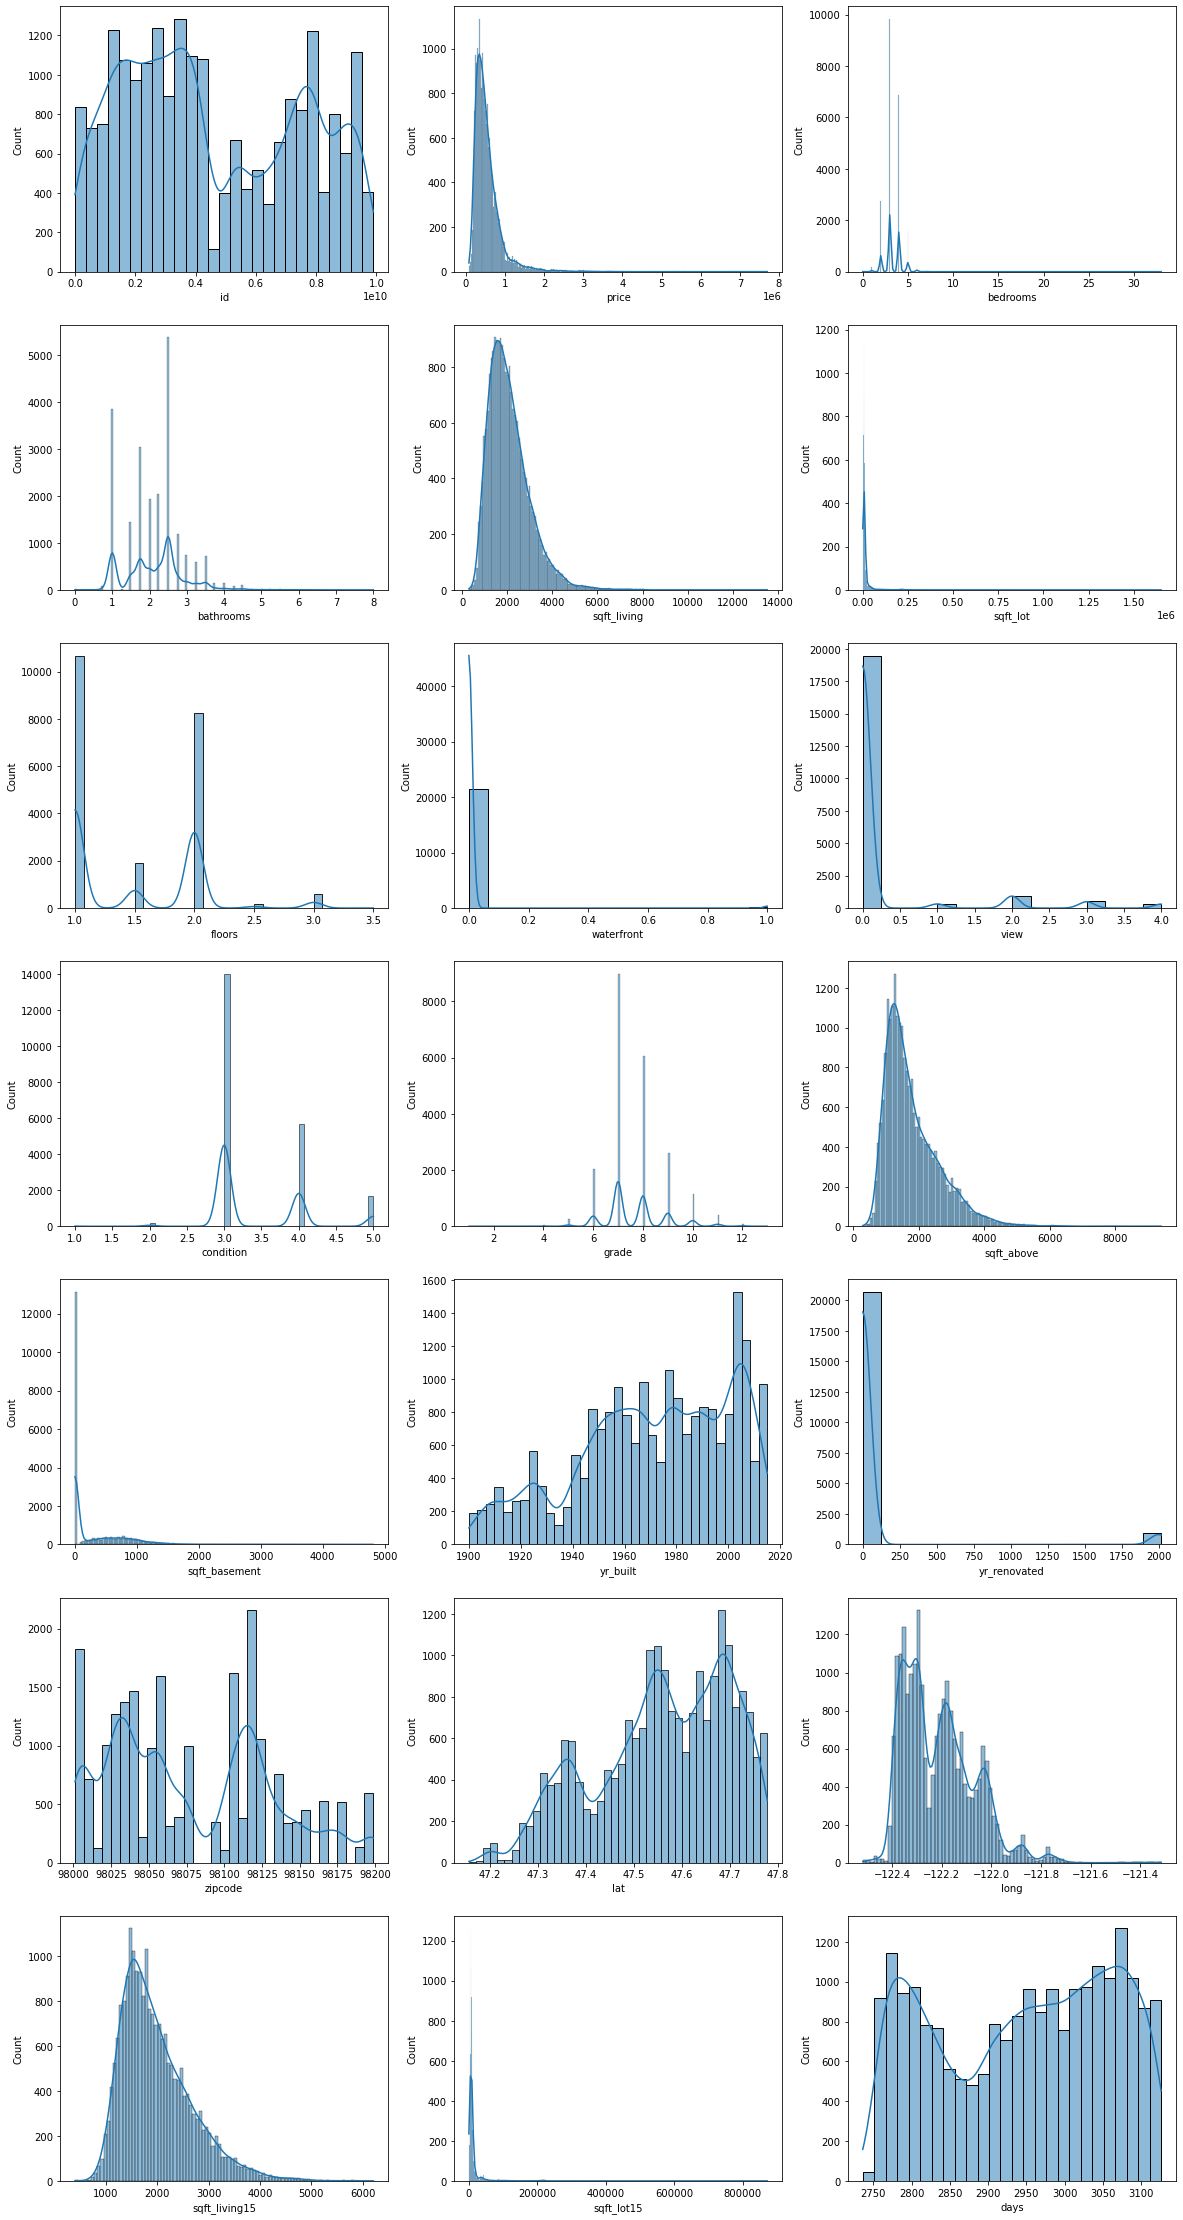

In [9]:
#Histogram plot for each features

# We have 20 features to plot at 7x3 subplots. 
plot_col_num = 3
plot_row_number = 7

#creating total number of plot for histogram
fig,axes = plt.subplots(plot_row_number,plot_col_num, figsize=(20,40))

#creating numeric feature list (here all features are numeric)
num_col = list(housing.columns)

for col_name in num_col:
    plt.subplot(plot_row_number,plot_col_num,(num_col.index(col_name)+1))
    sns.histplot(housing[col_name],kde=True)

1. **'bedrooms', 'yr_renovated','bathrooms'** are categorical having outlier.
2. **'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15'** are heavily skewed continuous parameters having outlier.

##### Outlier removal of categorical features

In [10]:
housing['yr_renovated'].value_counts()

0       20699
2014       91
2013       37
2003       36
2005       35
        ...  
1951        1
1959        1
1948        1
1954        1
1944        1
Name: yr_renovated, Length: 70, dtype: int64

$\because yr\_renovated$ contains $0$ at most of the time. I don't think it can be a very good predictor. So I remove the $yr\_renovated$ column from the dataset

In [11]:
housing.drop(['yr_renovated'],axis=1,inplace=True)

In [12]:
housing['bedrooms'].value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      199
7       38
0       13
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

Seems $33$ numbers of bedrooms is kind of outlier. So we can remove it.

In [13]:
housing.drop(index = housing.loc[housing.bedrooms==33].index,inplace=True)

In [14]:
housing['bathrooms'].value_counts()

2.50    5380
1.00    3852
1.75    3047
2.25    2047
2.00    1930
1.50    1446
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      72
4.75      23
5.00      21
5.25      13
0.00      10
5.50      10
1.25       9
6.00       6
0.50       4
5.75       4
6.75       2
8.00       2
6.25       2
6.50       2
7.50       1
7.75       1
Name: bathrooms, dtype: int64

Even though **'bathrooms'** should have been categorical in nature with integer number. The data shows little continuous. So, It is bit confusing and I keep it as it is.

In [15]:
housing.shape

(21612, 20)

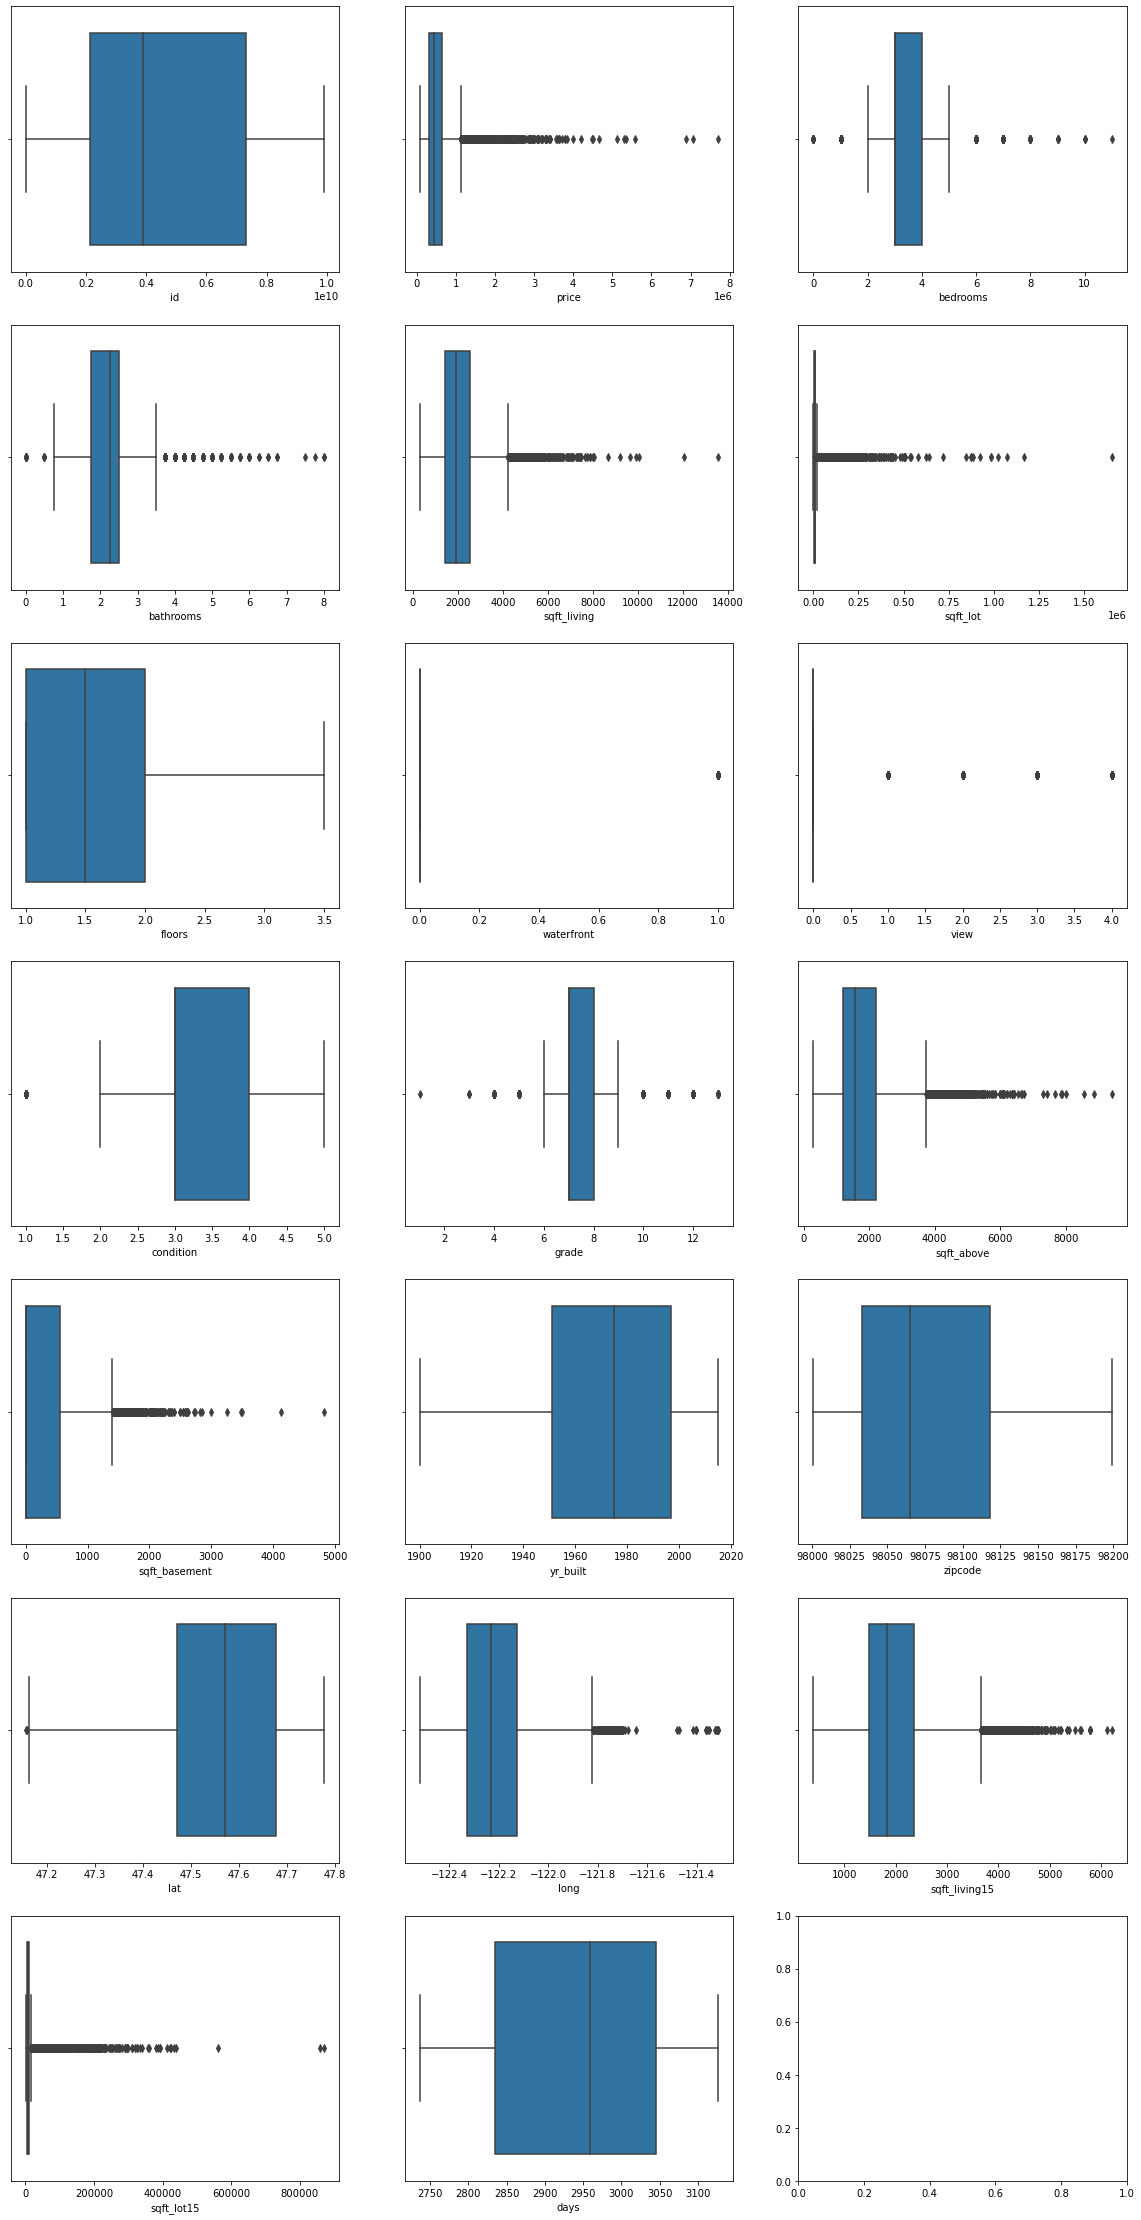

In [16]:
#Box plot for each features to cross-check outliers

# We have 20 features to plot at 7x3 subplots. 
plot_col_num = 3
plot_row_number = 7

#creating total number of plot for histogram
fig,axes = plt.subplots(plot_row_number,plot_col_num, figsize=(20,40))

#creating numeric feature list (here all features are numeric)
num_col = list(housing.columns)

for col_name in num_col:
        plt.subplot(plot_row_number,plot_col_num,(num_col.index(col_name)+1))
        sns.boxplot(x=housing[col_name])

**'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15'** have outliers.

##### Outlier removal of continuous features

In [17]:
#Creating shallow copy of housing for further analysis
housing_mod = housing.copy()

In [18]:
outlier_col = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15']

for col_name in outlier_col:
    Q1 = housing[col_name].quantile(0.25)
    Q3 = housing[col_name].quantile(0.75)
    IQR = Q3 - Q1
    UL = Q3 + 1.5 * IQR
    LL = Q1 - 1.5 * IQR
    housing_mod = housing_mod.loc[(housing_mod[col_name]<=UL) & (housing_mod[col_name]>=LL)]

# calculating % data loss after removing outlier
data_loss = (1 - housing_mod.shape[0]/housing.shape[0])*100
print('data_loss after removing outlier = ',np.round(data_loss,2),'%')

data_loss after removing outlier =  15.69 %


Let's plot again after removing oulier

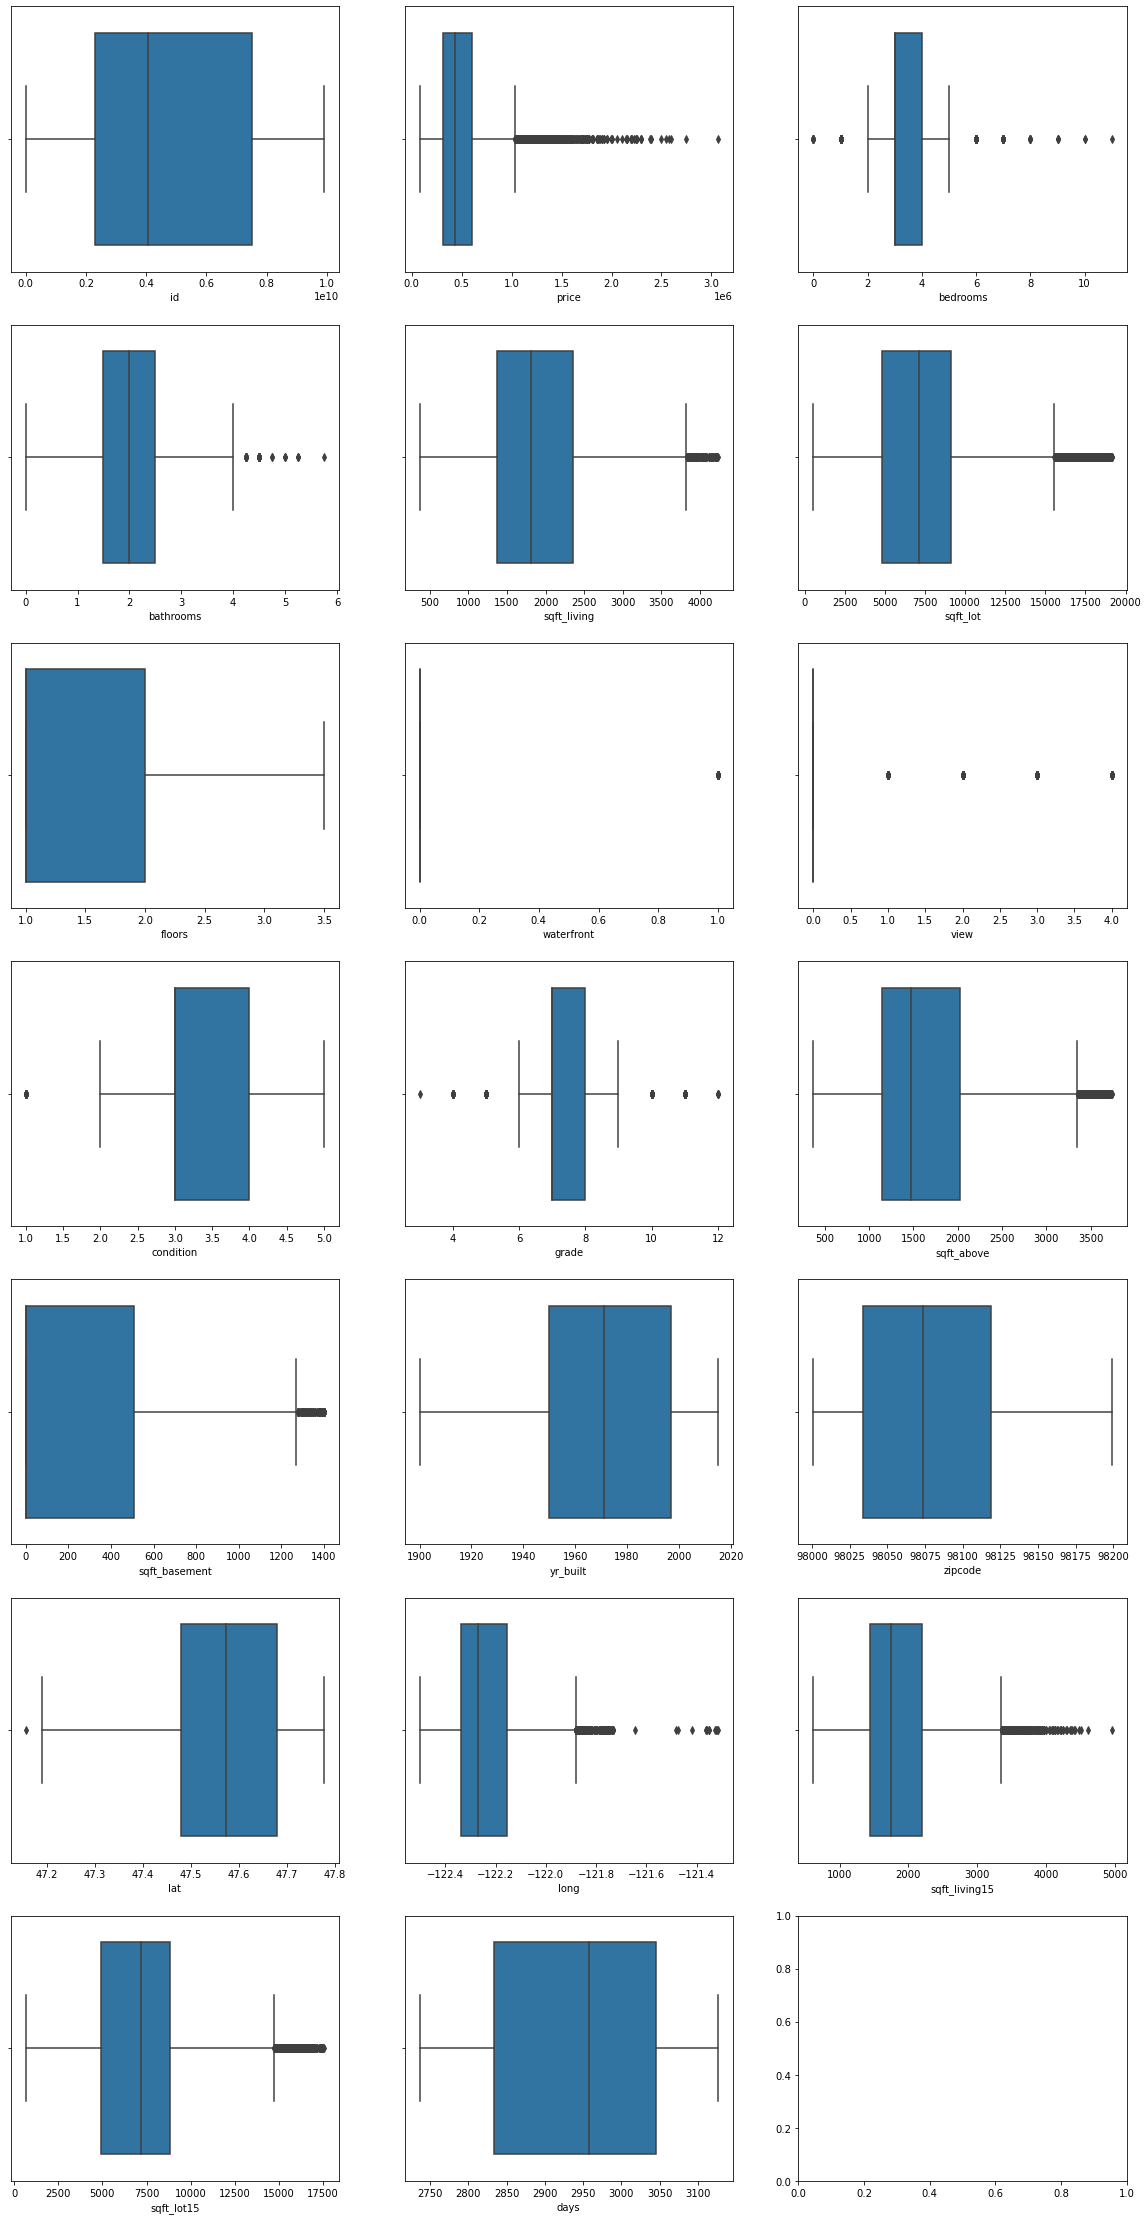

In [19]:
#Box plot for each features to cross-check outliers

# We have 20 features to plot at 7x3 subplots. 
plot_col_num = 3
plot_row_number = 7

#creating total number of plot for histogram
fig,axes = plt.subplots(plot_row_number,plot_col_num, figsize=(20,40))

#creating numeric feature list (here all features are numeric)
num_col = list(housing_mod.columns)

for col_name in num_col:
        plt.subplot(plot_row_number,plot_col_num,(num_col.index(col_name)+1))
        sns.boxplot(x=housing_mod[col_name])

### Feature selection

1. **id**, **zipcode** and **days** are not very useful for this analyis so let's remove these.

In [20]:
housing_mod.drop(['id','zipcode','days'],axis=1,inplace=True)

In [21]:
# checking remaining features
housing_mod.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'lat', 'long', 'sqft_living15',
       'sqft_lot15'],
      dtype='object')

Let's create some Seaborn pairplots for the features to get a feel for how the various features are distributed vis-a-vis the price as well as the number of bedrooms

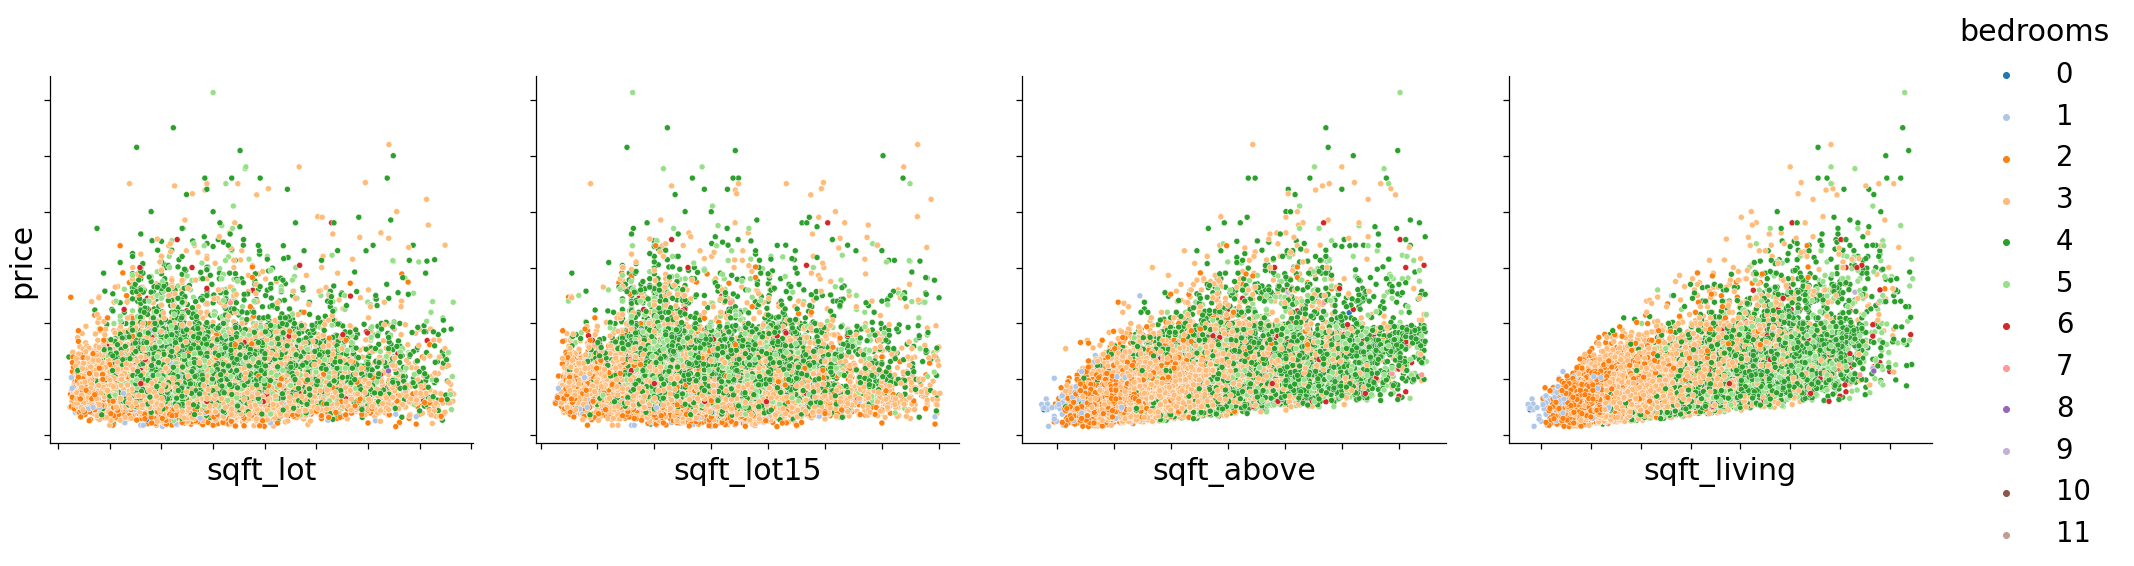

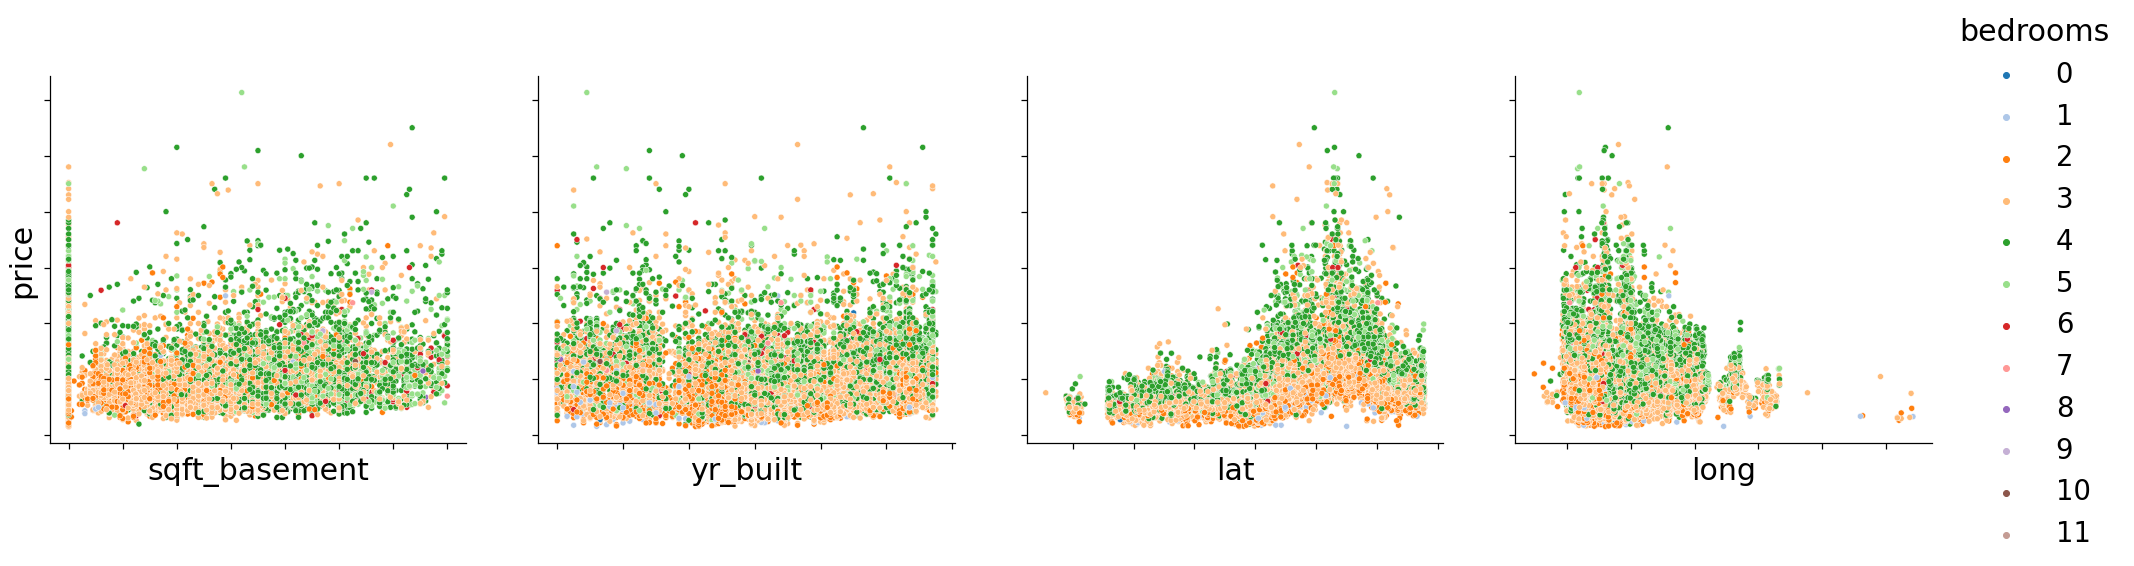

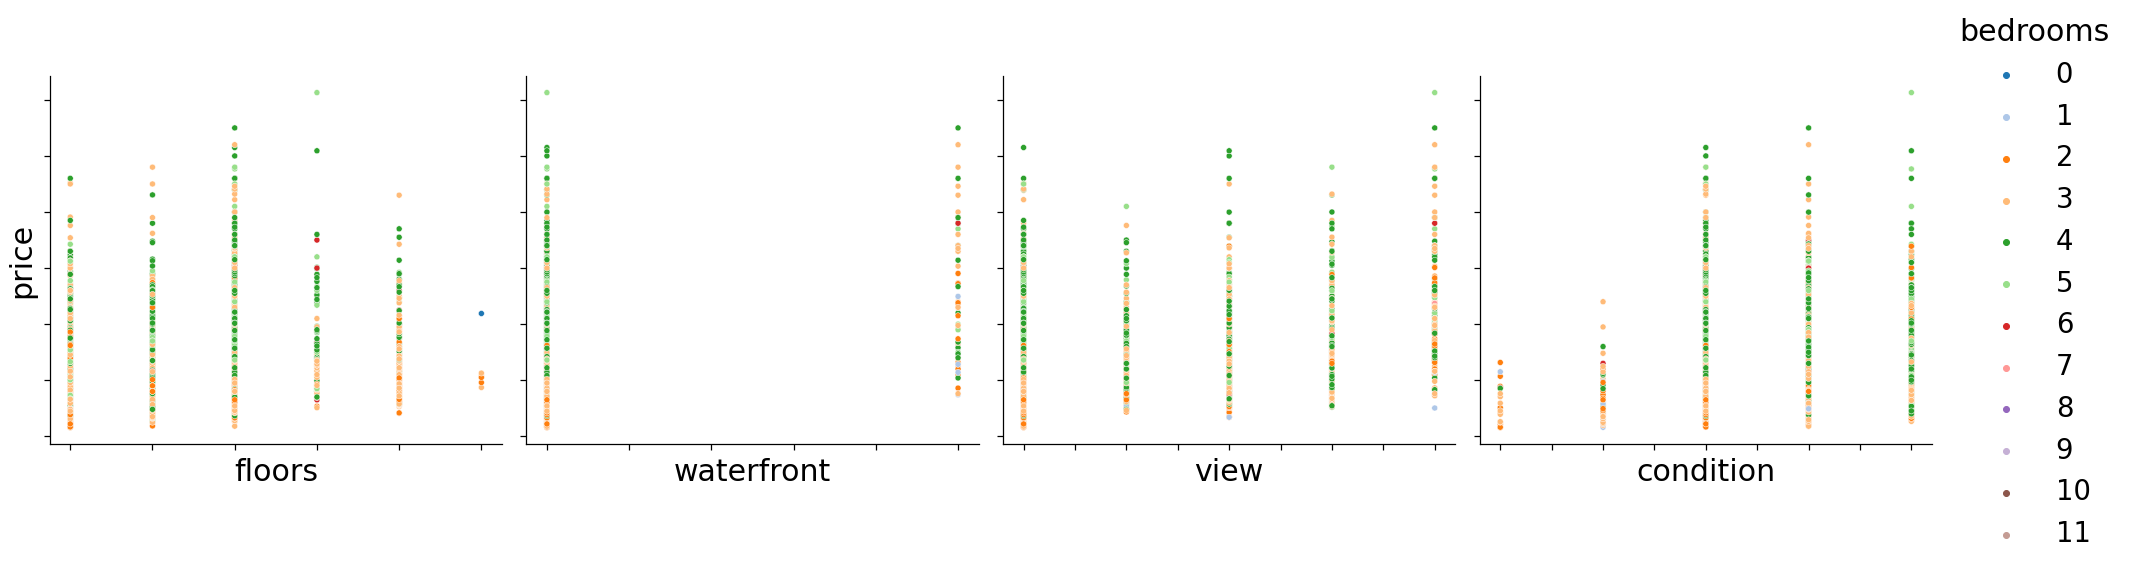

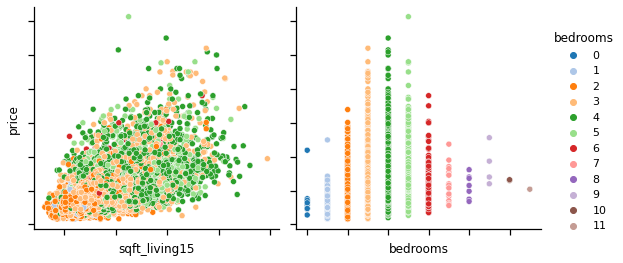

In [22]:
with sns.plotting_context("notebook",font_scale=2.5):
    g = sns.pairplot(x_vars=['sqft_lot','sqft_lot15','sqft_above','sqft_living'],y_vars=['price'],
                 data=housing_mod,height=7,hue='bedrooms',palette='tab20')
    h = sns.pairplot(x_vars=['sqft_basement','yr_built','lat','long'],y_vars=['price'],
                 data=housing_mod,height=7,hue='bedrooms',palette='tab20')
    i = sns.pairplot(x_vars=['floors','waterfront','view', 'condition'],y_vars=['price'],
             data=housing_mod,height=7,hue='bedrooms',palette='tab20')
with sns.plotting_context("notebook",font_scale=1):    
    k = sns.pairplot(x_vars=['sqft_living15','bedrooms'],y_vars=['price'],
             data=housing_mod,height=4,hue='bedrooms',palette='tab20')
    
g.set(xticklabels=[],yticklabels=[])
h.set(xticklabels=[],yticklabels=[])
i.set(xticklabels=[],yticklabels=[])
k.set(xticklabels=[],yticklabels=[])

plt.show()

**'Sqft_above', 'sqft_living' and 'sqft_living15'** have good linearship relation with price. So, we need to keep these 3 features for prediction.

Let's check correlation of individual features with price.

In [23]:
housing_mod.corr().price.abs().sort_values(ascending=False)

price            1.000000
grade            0.618215
sqft_living      0.602265
sqft_living15    0.530945
sqft_above       0.491204
bathrooms        0.426860
lat              0.398443
view             0.336914
bedrooms         0.269986
floors           0.267683
sqft_basement    0.257785
waterfront       0.168333
condition        0.063422
long             0.023022
yr_built         0.018076
sqft_lot15       0.009653
sqft_lot         0.009561
Name: price, dtype: float64

**`'grade','Sqft_above', 'sqft_living' and 'sqft_living15'`** are very good features to predict.

$\because$ **`'condition','long','yr_built','sqft_lot15'and'sqft_lot'`** have very week correlation with price, I can remove those features.

In [24]:
housing_mod.drop(['condition','long','yr_built','sqft_lot15','sqft_lot'],axis=1,inplace=True)

#### Correlation

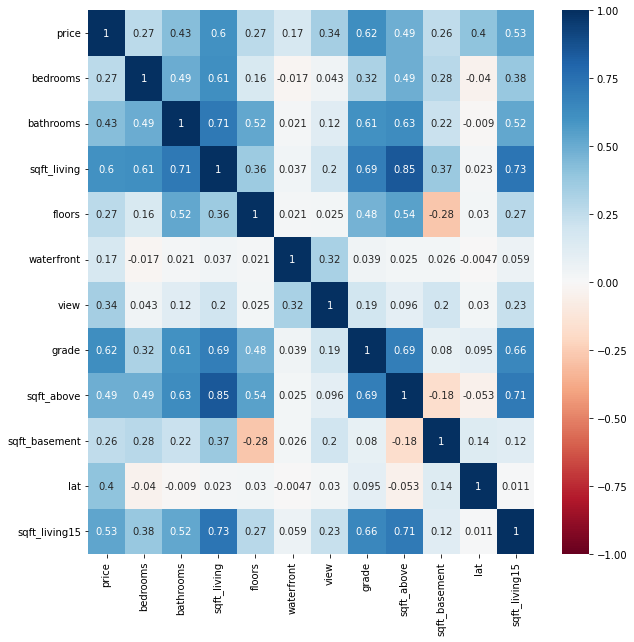

In [25]:
# Let's check any further multicollinearity
plt.figure(figsize=(10,10))
sns.heatmap(housing_mod.corr(),cmap='RdBu',center=0,vmin=-1,vmax=1,annot=True)
plt.show()

$\because$ **`'grade','Sqft_above', 'sqft_living' and 'sqft_living15'`** are very good features to predict we can remove those features even though they are strong collinearity among themshelves.

#### VIF Analysis

In [26]:
# checking remaining features
print(housing_mod.columns)
print(len(housing_mod.columns))

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront',
       'view', 'grade', 'sqft_above', 'sqft_basement', 'lat', 'sqft_living15'],
      dtype='object')
12


In [27]:
#creating Matrix for VIF analysis
X = housing_mod.drop(['grade','sqft_living','sqft_above','sqft_living15','price'],axis=1)

In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
VIF_data = pd.DataFrame()
VIF_data['feature'] = X.columns
VIF_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
VIF_data.sort_values(by='VIF',ascending=False)

,feature,VIF
0,bedrooms,20.966485
6,lat,19.918443
1,bathrooms,19.180184
2,floors,14.948428
5,sqft_basement,2.100748
4,view,1.256375
3,waterfront,1.121939


In [29]:
#Removing 'bedrooms'
X.drop(['bedrooms','bathrooms'],axis=1, inplace=True)

#Checking VIF for remaining features
VIF_data = pd.DataFrame()
VIF_data['feature'] = X.columns
VIF_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
VIF_data.sort_values(by='VIF',ascending=False)

,feature,VIF
4,lat,10.692964
0,floors,9.198052
3,sqft_basement,1.666141
2,view,1.252147
1,waterfront,1.121263


In [30]:
#Removing 'bedrooms'
X.drop(['floors'],axis=1, inplace=True)

#Checking VIF for remaining features
VIF_data = pd.DataFrame()
VIF_data['feature'] = X.columns
VIF_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
VIF_data.sort_values(by='VIF',ascending=False)

,feature,VIF
2,sqft_basement,1.526025
3,lat,1.482652
1,view,1.244233
0,waterfront,1.121260


### Model Building

In [31]:
# Feature Matrix
X = housing_mod[list(X.columns) + ['grade','sqft_living','sqft_above','sqft_living15']]
X.head(2)

,waterfront,view,sqft_basement,lat,grade,sqft_living,sqft_above,sqft_living15
0,0,0,0,47.5112,7,1180,1180,1340
1,0,0,400,47.7210,7,2570,2170,1690


In [32]:
# Target vector
y = housing_mod.loc[:,'price']
y.head(2)

0    221900
1    538000
Name: price, dtype: int64

#### Linear regression

In [33]:
for random_state in range(0,50,10):
    #creating training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8, random_state=random_state)

    #Train the model and predicting the test dataset
    model = LinearRegression()      # Instatiate
    model.fit(X_train, y_train)     # Feeding data into model
    y_pred = model.predict(X_test)  # Predicting test set

    r2 = r2_score(y_test,y_pred)
    print(f'r2 at random_state {random_state} = ',np.round(r2,2))

r2 at random_state 0 =  0.62
r2 at random_state 10 =  0.62
r2 at random_state 20 =  0.61
r2 at random_state 30 =  0.61
r2 at random_state 40 =  0.64


R_2 value I'm getting is moderate. Let's plot **Predicted vs Actual**.

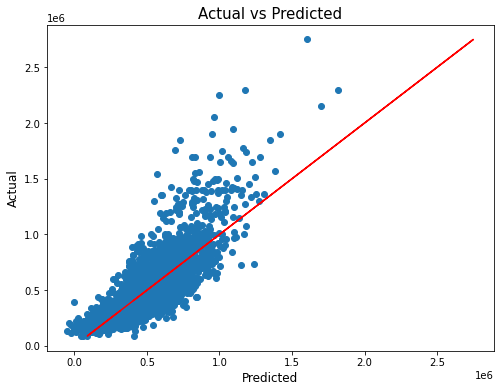

In [34]:
plt.figure(figsize = (8,6))
plt.scatter(x=y_pred,y=y_test,)
plt.plot(y_test,y_test,'r')
plt.xlabel('Predicted',fontsize=12)
plt.ylabel('Actual',fontsize=12)
plt.title('Actual vs Predicted',fontsize=15)
plt.show()

#### Ridge regression

In [35]:
for random_state in range(0,50,10):
    #creating training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8, random_state=random_state)

    #Train the model and predicting the test dataset
    model = Ridge()      # Instatiate
    model.fit(X_train, y_train)     # Feeding data into model
    y_pred = model.predict(X_test)  # Predicting test set

    r2 = r2_score(y_test,y_pred)
    print(f'r2 at random_state {random_state} = ',np.round(r2,2))

r2 at random_state 0 =  0.62
r2 at random_state 10 =  0.62
r2 at random_state 20 =  0.61
r2 at random_state 30 =  0.61
r2 at random_state 40 =  0.64


There is no major difference in result between normal **`'Linear regression'`** and **`'Ridge regression'`**

#### Random forest

In [36]:
for random_state in range(0,50,10):
    #creating training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8, random_state=random_state)

    #Train the model and predicting the test dataset
    model = RandomForestRegressor()      # Instatiate
    model.fit(X_train, y_train)     # Feeding data into model
    y_pred = model.predict(X_test)  # Predicting test set

    r2 = r2_score(y_test,y_pred)
    print(f'r2 at random_state {random_state} = ',np.round(r2,2))

r2 at random_state 0 =  0.78
r2 at random_state 10 =  0.78
r2 at random_state 20 =  0.78
r2 at random_state 30 =  0.77
r2 at random_state 40 =  0.79


With **`Random forest`** reult is much better. Let's plot the data.

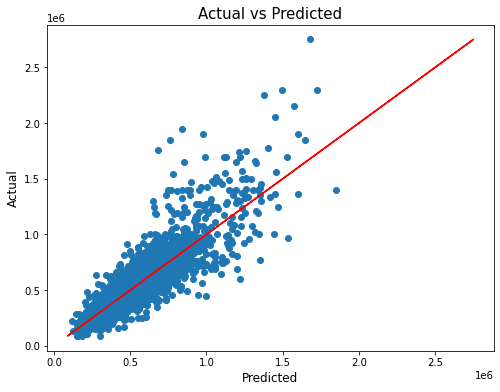

In [37]:
plt.figure(figsize = (8,6))
plt.scatter(x=y_pred,y=y_test,)
plt.plot(y_test,y_test,'r')
plt.xlabel('Predicted',fontsize=12)
plt.ylabel('Actual',fontsize=12)
plt.title('Actual vs Predicted',fontsize=15)
plt.show()